In [1]:
import sqlite3
import pandas as pd
import altair as alt

In [2]:
con = sqlite3.connect("CL000_1M.db")

In [9]:
df = pd.read_sql("SELECT * FROM candles where day = '20181101' order by dt", con)

In [17]:
df['date'] = pd.to_datetime(df.dt)

In [19]:
df.set_index('dt')

,open,high,low,close,volume,day,date
dt,,,,,,,
20181101070000,64.88,65.01,64.86,64.98,376,20181101,2018-11-01 07:00:00
20181101070100,64.98,65.03,64.97,65.01,171,20181101,2018-11-01 07:01:00
20181101070200,65.02,65.02,64.99,64.99,63,20181101,2018-11-01 07:02:00
20181101070300,65.00,65.00,64.95,64.98,57,20181101,2018-11-01 07:03:00
20181101070400,64.98,65.02,64.98,65.01,47,20181101,2018-11-01 07:04:00
20181101070500,65.01,65.03,65.00,65.00,100,20181101,2018-11-01 07:05:00
20181101070600,65.01,65.01,64.99,65.00,23,20181101,2018-11-01 07:06:00
20181101070700,64.99,65.00,64.96,64.97,52,20181101,2018-11-01 07:07:00
20181101070800,64.96,64.97,64.95,64.97,68,20181101,2018-11-01 07:08:00


In [46]:
from decimal import *

def calculate_earnings(df, enter_price_type='close', exit_price_type='close', loss_limit=10, keep_period=60):
    result = []
    for i in range(len(df)):
        enter_price = df.iloc[i][enter_price_type]
        
        top_price = Decimal('-Infinity')
        bottom_price = Decimal('Infinity')
        top_price_index = i
        bottom_price_index = i
        
        call_earning = Decimal(0)
        call_earning_index = i
        pull_earning = Decimal(0)
        pull_earning_index = i

        call_loss = Decimal(0)
        call_loss_index = i
        pull_loss = Decimal(0)
        pull_loss_index = i
        
        for k in range(i+1, min(i+2+keep_period, len(df))):
            current_high = df.iloc[k]['high']
            current_low = df.iloc[k]['low']
            if (top_price < current_high):
                top_price_index = k
                top_price = current_high
            if (bottom_price > current_low):
                bottom_price_index = k
                bottom_price = current_low
            exit_price = df.iloc[k][exit_price_type]
            current_call_earning = exit_price - enter_price
            current_pull_earning = enter_price - exit_price
            if (call_earning < current_call_earning):
                call_earning_index = k
                call_earning = current_call_earning
            if (pull_earning < current_pull_earning):
                pull_earning_index = k
                pull_earning = current_pull_earning
            current_pull_loss = exit_price - enter_price
            current_call_loss = enter_price - exit_price
            if (call_loss < loss_limit and call_loss < current_call_loss):
                call_loss_index = k
                call_loss = current_call_loss
            if (pull_loss < loss_limit and pull_loss < current_pull_loss):
                pull_loss_index = k
                pull_loss = current_pull_loss
        row = {'dt': df.iloc[i]['dt']}
        row['enter_price'] = enter_price
        row['call_earning'] = call_earning
        row['call_earning_tikcs'] = call_earning_index - i
        row['call_loss'] = call_loss
        row['call_loss_tikcs'] = call_loss_index - i
        row['pull_earning'] = pull_earning
        row['pull_earning_tikcs'] = pull_earning_index - i
        row['pull_loss'] = pull_loss
        row['pull_loss_tikcs'] = pull_loss_index - i
        result.append(row)
    return pd.DataFrame(result)

In [47]:
calculate_earnings(df)

,call_earning,call_earning_tikcs,call_loss,call_loss_tikcs,dt,enter_price,pull_earning,pull_earning_tikcs,pull_loss,pull_loss_tikcs
0,0.08,35,0.03,10,20181101070000,64.98,0.03,10,0.08,35
1,0.05,34,0.06,9,20181101070100,65.01,0.06,9,0.05,34
2,0.07,33,0.04,8,20181101070200,64.99,0.04,8,0.07,33
3,0.08,32,0.03,7,20181101070300,64.98,0.03,7,0.08,32
4,0.05,31,0.06,6,20181101070400,65.01,0.06,6,0.05,31
5,0.06,30,0.05,5,20181101070500,65.00,0.05,5,0.06,30
6,0.06,29,0.05,4,20181101070600,65.00,0.05,4,0.06,29
7,0.09,28,0.02,3,20181101070700,64.97,0.02,3,0.09,28
8,0.09,27,0.02,2,20181101070800,64.97,0.02,2,0.09,27
9,0.08,26,0.03,1,20181101070900,64.98,0.03,1,0.08,26


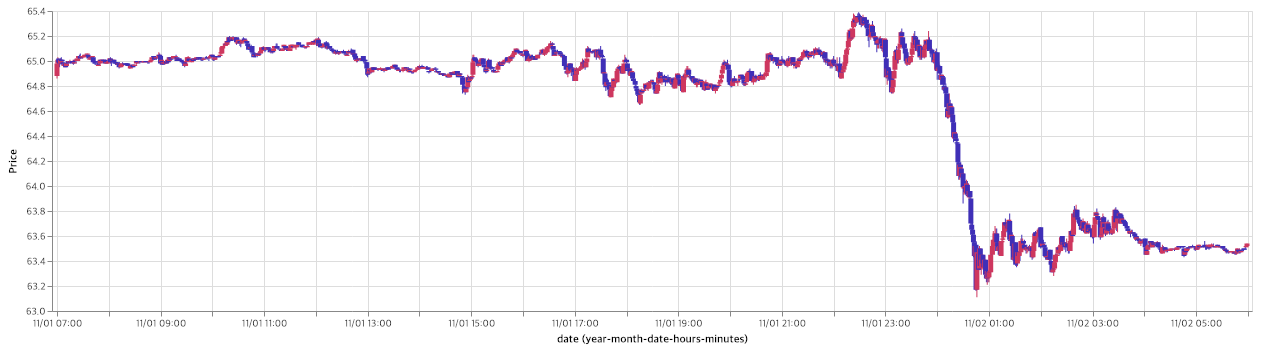

In [22]:
open_close_color = alt.condition("datum.open < datum.close",
                                 alt.value("#ce375f"),
                                 alt.value("#3f2fb7"))

rule = alt.Chart(df).mark_rule().encode(
    alt.X(
        'yearmonthdatehoursminutes(date):T',
#         scale=alt.Scale(domain=[{"month": 6, "date": 1, "year": 2009},
#                                 {"month": 6, "date": 2, "year": 2009}]),
        axis=alt.Axis(format='%m/%d %H:%M')
    ),
    alt.Y(
        'low',
        scale=alt.Scale(zero=False),
        axis=alt.Axis(title='Price')
    ),
    alt.Y2('high'),
    color=open_close_color
)

bar = alt.Chart(df).mark_bar().encode(
    x='yearmonthdatehoursminutes(date):T',
    y='open',
    y2='close',
    color=open_close_color
)

(rule + bar).properties(width=1200)

In [20]:
from sqlalchemy import create_engine
from sqlalchemy.orm import sessionmaker
from sqlalchemy.sql import func

from entity import Candle, Base

In [22]:
engine=create_engine('sqlite:///CL018_1M.db')
session = sessionmaker(bind=engine)()
Base.metadata.create_all(engine)

In [24]:
session.query(func.max(Candle.dt)).one()[0]

In [12]:
res[0]

'20181110065900'

In [8]:
min

'20100219024700'

In [1]:
from IPython.core.display import HTML
HTML('''
<h1>Hello DOM!</h1>
''')

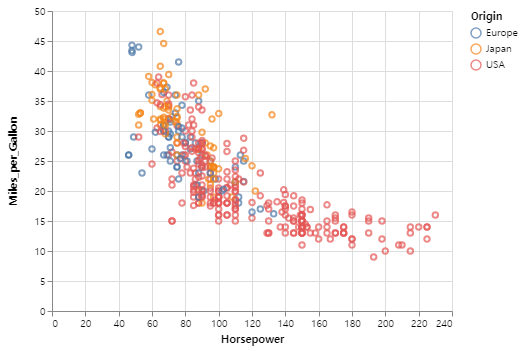

In [1]:
import altair as alt

# load a simple dataset as a pandas DataFrame
from vega_datasets import data
cars = data.cars()

alt.Chart(cars).mark_point().encode(
    x='Horsepower',
    y='Miles_per_Gallon',
    color='Origin',
).interactive()

In [15]:
import pandas as pd
data = pd.DataFrame({'a': ['20170101100101','20170201100101','20170103100101'],
                     'b': [2, 7, 4]})

In [7]:
import altair as alt
chart = alt.Chart(data)

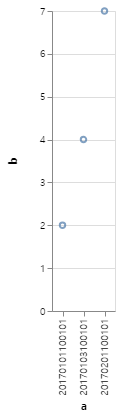

In [16]:
alt.Chart(data).mark_point().encode(x='a', y='b')

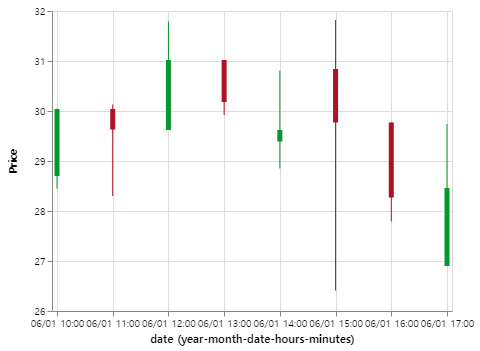

In [71]:
source = pd.DataFrame(
[
      {
        "date": "2009-06-01 10:00:00",
        "open": 28.7,
        "high": 30.05,
        "low": 28.45,
        "close": 30.04,
        "signal": "short",
        "ret": -4.89396411092985
      },
      {
        "date": "2009-06-01 11:00:00",
        "open": 30.04,
        "high": 30.13,
        "low": 28.3,
        "close": 29.63,
        "signal": "short",
        "ret": -0.322580645161295
      },
      {
        "date": "2009-06-01 12:00:00",
        "open": 29.62,
        "high": 31.79,
        "low": 29.62,
        "close": 31.02,
        "signal": "short",
        "ret": 3.68663594470045
      },
      {
        "date": "2009-06-01 13:00:00",
        "open": 31.02,
        "high": 31.02,
        "low": 29.92,
        "close": 30.18,
        "signal": "short",
        "ret": 4.51010886469673
      },
      {
        "date": "2009-06-01 14:00:00",
        "open": 29.39,
        "high": 30.81,
        "low": 28.85,
        "close": 29.62,
        "signal": "short",
        "ret": 6.08424336973478
      },
      {
        "date": "2009-06-01 15:00:00",
        "open": 30.84,
        "high": 31.82,
        "low": 26.41,
        "close": 29.77,
        "signal": "short",
        "ret": 1.2539184952978
      },
      {
        "date": "2009-06-01 16:00:00",
        "open": 29.77,
        "high": 29.77,
        "low": 27.79,
        "close": 28.27,
        "signal": "short",
        "ret": -5.02431118314424
      },
      {
        "date": "2009-06-01 17:00:00",
        "open": 26.9,
        "high": 29.74,
        "low": 26.9,
        "close": 28.46,
        "signal": "short",
        "ret": -5.46623794212217
      }
    ]
)
open_close_color = alt.condition("datum.open < datum.close",
                                 alt.value("#06982d"),
                                 alt.value("#ae1325"))

rule = alt.Chart(source).mark_rule().encode(
    alt.X(
        'yearmonthdatehoursminutes(date):T',
#         scale=alt.Scale(domain=[{"month": 6, "date": 1, "year": 2009},
#                                 {"month": 6, "date": 2, "year": 2009}]),
        axis=alt.Axis(format='%m/%d %H:%M')
    ),
    alt.Y(
        'low',
        scale=alt.Scale(zero=False),
        axis=alt.Axis(title='Price')
    ),
    alt.Y2('high'),
    color=open_close_color
)

bar = alt.Chart(source).mark_bar().encode(
    x='yearmonthdatehoursminutes(date):T',
    y='open',
    y2='close',
    color=open_close_color
)

(rule + bar)

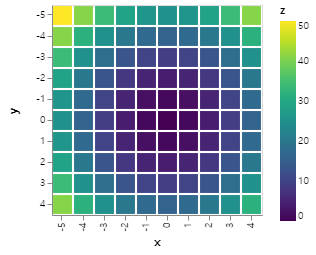

In [28]:
import altair as alt
import numpy as np
import pandas as pd

# Compute x^2 + y^2 across a 2D grid
x, y = np.meshgrid(range(-5, 5), range(-5, 5))
z = x ** 2 + y ** 2

# Convert this grid to columnar data expected by Altair
source = pd.DataFrame({'x': x.ravel(),
                     'y': y.ravel(),
                     'z': z.ravel()})

alt.Chart(source).mark_rect().encode(
    x='x:O',
    y='y:O',
    color='z:Q'
)

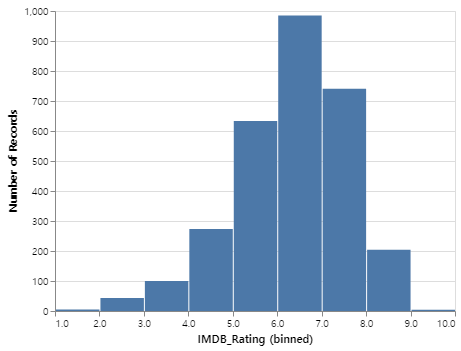

In [32]:
import altair as alt
from vega_datasets import data

source = data.movies.url

alt.Chart(source).mark_bar().encode(
    alt.X("IMDB_Rating:Q", bin=True),
    y='count()',
)

In [33]:
source

'https://vega.github.io/vega-datasets/data/movies.json'

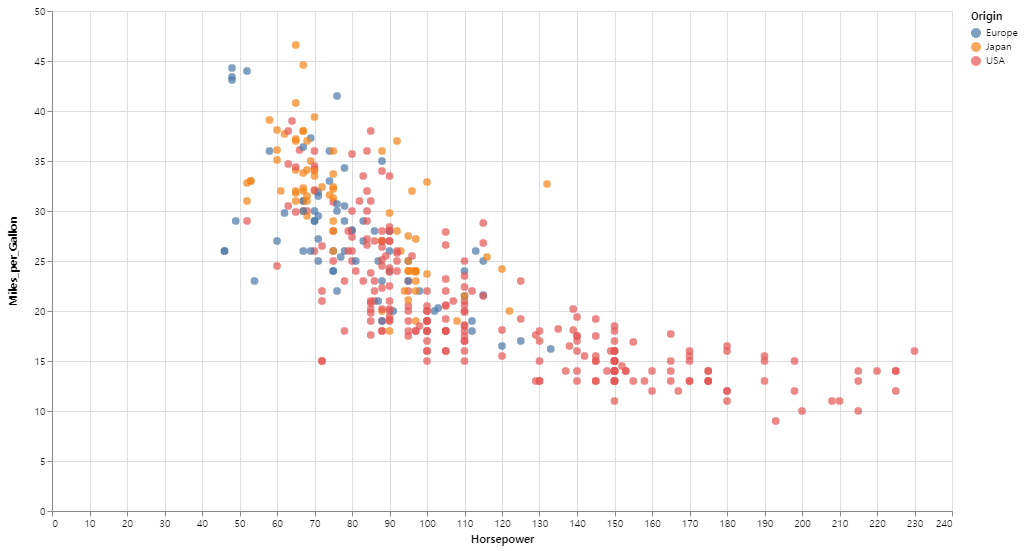

In [39]:
import altair as alt
from vega_datasets import data

source = data.cars()

alt.Chart(source).mark_circle(size=60).encode(
    x='Horsepower',
    y='Miles_per_Gallon',
    color='Origin',
    tooltip=['Name', 'Origin', 'Horsepower', 'Miles_per_Gallon']
).properties(width=900, height=500).interactive()

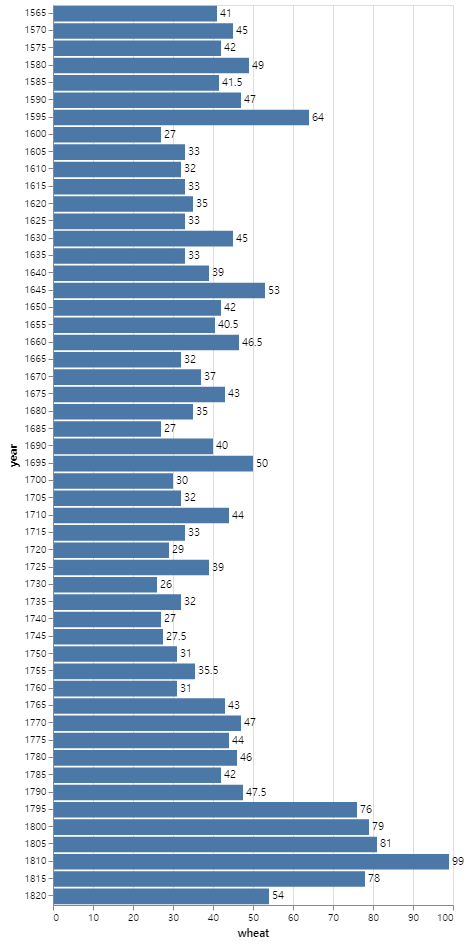

In [46]:
import altair as alt
from vega_datasets import data

source = data.wheat()

bars = alt.Chart(source).mark_bar().encode(
    x='wheat:Q',
    y="year:O"
)

text = bars.mark_text(
    align='left',
    baseline='middle',
    dx=3  # Nudges text to right so it doesn't appear on top of the bar
).encode(
    text='wheat:Q'
)

(bars + text).properties(height=900)

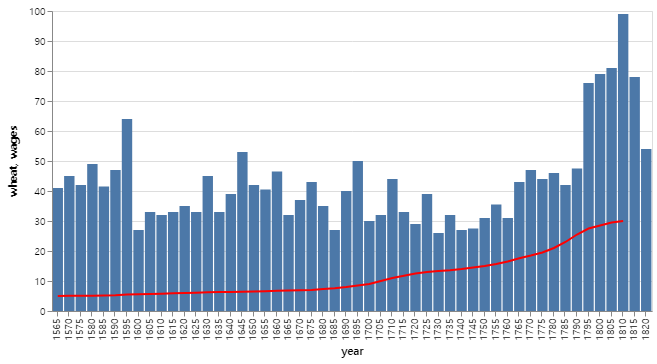

In [47]:
import altair as alt
from vega_datasets import data

source = data.wheat()

base = alt.Chart(source).encode(x='year:O')

bar = base.mark_bar().encode(y='wheat:Q')

line =  base.mark_line(color='red').encode(
    y='wages:Q'
)

(bar + line).properties(width=600)

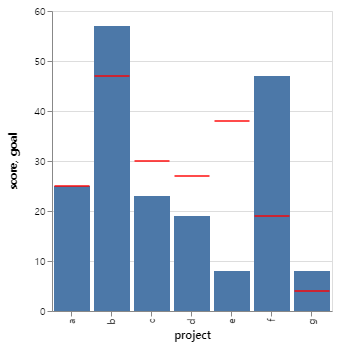

In [50]:
import altair as alt
import pandas as pd

source = pd.DataFrame({
    'project': ['a', 'b', 'c', 'd', 'e', 'f', 'g'],
    'score': [25, 57, 23, 19, 8, 47, 8],
    'goal': [25, 47, 30, 27, 38, 19, 4]
})

base = alt.Chart(source)

bar = base.mark_bar().encode(
    x='project',
    y='score'
)

tick = base.mark_tick(
    color='red',
    thickness=2
).encode(
    x='project',
    y='goal'
)

(bar + tick).configure_tick(
    bandSize=35  # controls the width of the tick
).configure_scale(
    rangeStep=40  # controls the width of the bar
)

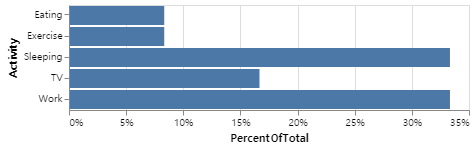

In [51]:
import altair as alt
import pandas as pd

source = pd.DataFrame({'Activity': ['Sleeping', 'Eating', 'TV', 'Work', 'Exercise'],
                           'Time': [8, 2, 4, 8, 2]})

alt.Chart(source).mark_bar().encode(
    alt.X('PercentOfTotal:Q', axis=alt.Axis(format='.0%')),
    y='Activity:N'
).transform_window(
    TotalTime='sum(Time)',
    frame=[None, None]
).transform_calculate(
    PercentOfTotal="datum.Time / datum.TotalTime"
)

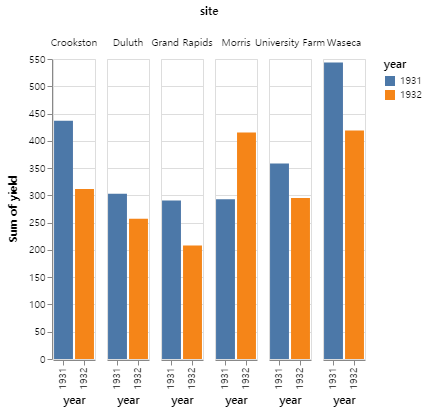

In [52]:
import altair as alt
from vega_datasets import data

source = data.barley()

alt.Chart(source).mark_bar().encode(
    x='year:O',
    y='sum(yield):Q',
    color='year:N',
    column='site:N'
)

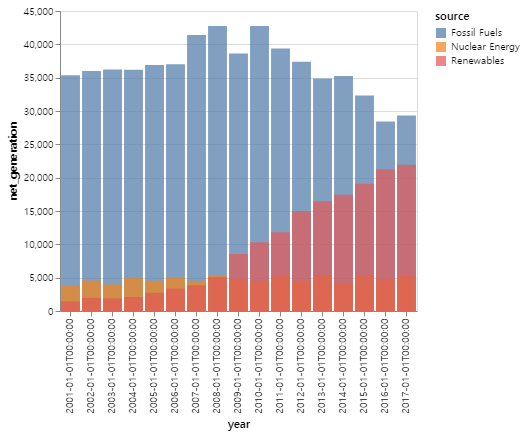

In [59]:
import altair as alt
from vega_datasets import data

source = data.iowa_electricity()

alt.Chart(source).mark_bar(opacity=0.7).encode(
    x='year:O',
    y=alt.Y('net_generation:Q', stack=None),
    color="source",
)

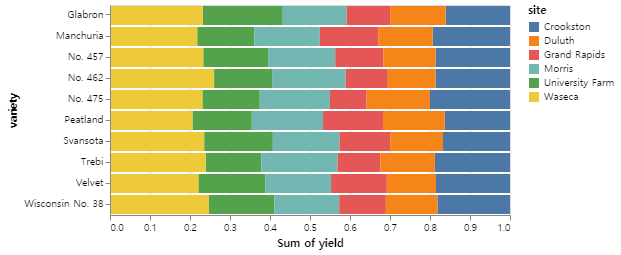

In [62]:
import altair as alt
from vega_datasets import data

source = data.barley()

alt.Chart(source).mark_bar().encode(
    x=alt.X('sum(yield)', stack="normalize"),
    y='variety',
    color='site'
)

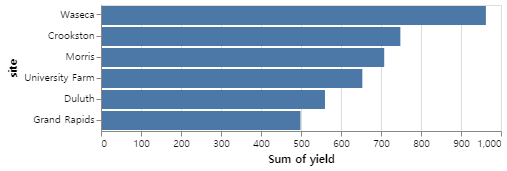

In [63]:
import altair as alt
from vega_datasets import data

source = data.barley()

alt.Chart(source).mark_bar().encode(
    x='sum(yield):Q',
    y=alt.Y(
        'site:N',
        sort=alt.EncodingSortField(
            field="yield",  # The field to use for the sort
            op="sum",  # The operation to run on the field prior to sorting
            order="descending"  # The order to sort in
        )
    )
)

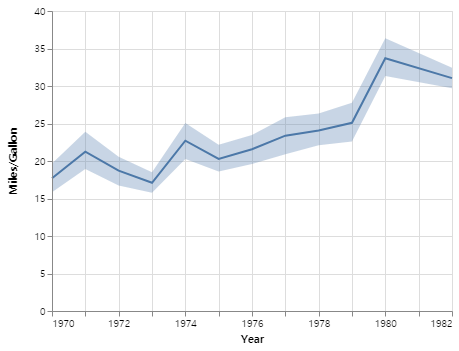

In [66]:
import altair as alt
from vega_datasets import data

source = data.cars()

# Configure the base chart
base = alt.Chart(source)

# Configure the line
line = base.mark_line().encode(
    x='Year',
    y='mean(Miles_per_Gallon)'
)

# Configure the confidence interval
confidence_interval = base.mark_area(opacity=0.3).encode(
    x='Year',
    y=alt.Y('ci0(Miles_per_Gallon)', axis=alt.Axis(title='Miles/Gallon')),
    y2='ci1(Miles_per_Gallon)'
)

# Draw the chart
confidence_interval + line

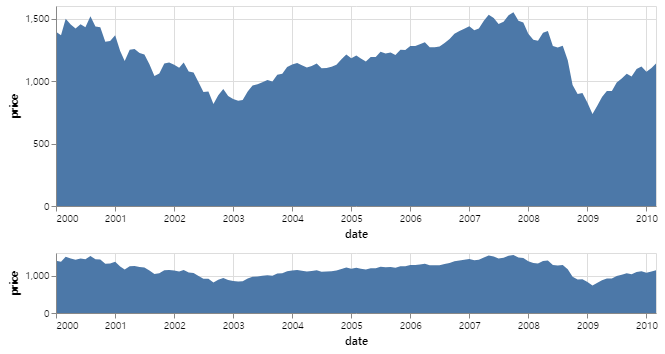

In [67]:
import altair as alt
from vega_datasets import data

source = data.sp500.url

brush = alt.selection(type='interval', encodings=['x'])

upper = alt.Chart().mark_area().encode(
    alt.X('date:T', scale={'domain': brush.ref()}),
    y='price:Q'
).properties(
    width=600,
    height=200
)

lower = upper.properties(
    height=60
).add_selection(brush)

alt.vconcat(upper, lower, data=source)

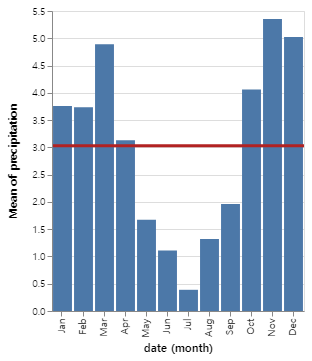

In [72]:
import altair as alt
from vega_datasets import data

source = data.seattle_weather()
brush = alt.selection(type='interval', encodings=['x'])

bars = alt.Chart().mark_bar().encode(
    x='month(date):O',
    y='mean(precipitation):Q',
    opacity=alt.condition(brush, alt.OpacityValue(1), alt.OpacityValue(0.7))
).add_selection(
    brush
)

line = alt.Chart().mark_rule(color='firebrick').encode(
    y='mean(precipitation):Q',
    size=alt.SizeValue(3)
).transform_filter(
    brush
)

alt.layer(bars, line, data=source)